<a href="https://colab.research.google.com/github/jacKlinc/german_char_recogniser/blob/main/mdl_german_char_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [74]:
from fastbook import *
from fastai.vision.all import *

In [3]:
path = Path('gdrive/MyDrive/Colab Notebooks')
Path.BASE_PATH = path

In [73]:
a = (path/'A').ls().sorted()
b = (path/'B').ls().sorted()

In [5]:
len(b)

8668

In [6]:
img = Image.open(a[100])
img

In [7]:
img_t = tensor(img)

In [8]:
df = pd.DataFrame(img_t)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,131,255,193,6,68,255,131,6,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,255,255,255,255,255,255,255,255,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,199,255,255,255,255,255,255,255,255,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,87,255,255,255,255,255,255,255,255,255,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,78,255,255,255,255,255,224,239,255,255,255,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,208,255,255,255,236,93,0,208,255,255,236,0,0,0,0,0


The cell above shows how the image is simply made of black and white and pixels; the darker the pixel, the higher the number in the cell.

## Pixel Similarity
Find the mean shape of A and comapre each new image to that.

In [9]:
# get first 64 for testing
a_tensor = [tensor(Image.open(x)) for x in a[:64]]
b_tensor = [tensor(Image.open(x)) for x in b[:64]]

To make this into one big matrix a neural network can use we need to stack all the tensors on top of each other.

In [10]:
stacked_a = torch.stack(a_tensor)
stacked_b = torch.stack(b_tensor)

The data must be converted from a 0-255 scale to 0-1 for the neural network. The tensors are integers so they must be converted to floats too.

In [11]:
stacked_a = stacked_a.float()/255
stacked_b = stacked_b.float()/255

Find the mean of each matrix.

In [12]:
mean_a = stacked_a.mean(0)
mean_b = stacked_b.mean(0)

Getting the distance from the ideal (mean) character is going to determine how it is classified. There are two methods we can use:

1. L1 norm - absolute mean value. This subtracts the mean from each value in the tensor and makes it postive.
1. L2 norm - Root Mean Squared Error (RMSE). This subtracts the mean in the tensor but squares the difference. This makes for smaller errors having little weight and larger ones having quite an effect.



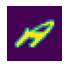

In [13]:
a0 = stacked_a[0]
show_image(a0)

In [14]:
dist_a_abs = (a0 - mean_a).abs().mean()
dist_a_rmse = ((a0 - mean_a)**2).mean().sqrt()
dist_a_abs, dist_a_rmse

(tensor(0.1174), tensor(0.2124))

In [15]:
dist_b_abs = (a0 - mean_b).abs().mean()
dist_b_rmse = ((a0 - mean_b)**2).mean().sqrt()
dist_b_abs, dist_b_rmse

(tensor(0.1813), tensor(0.2947))

Using either of the above approaches, the average distance between the "a" example and the ideal "a" is less than that between the "b" example. Either can be used to classify. Defining a function for each might be the most convenient way to proceed.

In [16]:
def abs_dist(ex, mean):
  return (ex - mean).abs().mean((-1, -2))

def rmse_dist(ex, mean):
  return ((ex - mean)**2).mean().sqrt()

abs_dist(a0, mean_b), rmse_dist(a0, mean_b)

(tensor(0.1813), tensor(0.2947))

Now the error between an example and the mean can be found easily. Defining a way to compare the error to other character is the next step.

The code below checks if the absolute mean error between an "a" example and the mean of "a" is less than that of a "b" example.

In [17]:
abs_dist(a0, mean_a) < abs_dist(a0, mean_b)

tensor(True)

In [18]:
def is_a(ex_a):
  return (abs_dist(ex_a, mean_a) < abs_dist(ex_a, mean_b)).float()

is_a(a0) 

tensor(1.)

### Create Validation Set
Gather validation data to measure accuracy of classification.

In [19]:
valid_stacked_a = torch.stack([tensor(Image.open(x)) 
                              for x in a[65:128]]).float()/255
                              
valid_stacked_b = torch.stack([tensor(Image.open(x)) 
                              for x in b[65:128]]).float()/255

valid_stacked_a.shape, valid_stacked_b.shape

(torch.Size([63, 28, 28]), torch.Size([63, 28, 28]))

In [20]:
accuracy_a =      is_a(valid_stacked_a) .mean()
accuracy_b = (1 - is_a(valid_stacked_b)).mean()

accuracy_a, accuracy_b

(tensor(0.9841), tensor(0.7302))

Next we need to find the distance from each value in the validation matrix from the ideal "a". This could be acheived by looping over the each value but this would be inefficient. 

Luckily, broadcasting exists, this is where PyTorch has tensors of different ranks and it expands the smaller one (```mean_a```) to the size of the larger one (```valid_stacked_a```) so that each value is operated on.

This makes things much faster because the operation is passed directly through C or if running on a GPU, it can be millions of times faster.

In [22]:
valid_a_dist = abs_dist(valid_stacked_a, mean_a)
valid_a_dist, valid_a_dist.shape

(tensor([0.0910, 0.1179, 0.1493, 0.1260, 0.1864, 0.1179, 0.1537, 0.1300, 0.1120, 0.1191, 0.1044, 0.1343, 0.1372, 0.1311, 0.1136, 0.1279, 0.1301, 0.1413, 0.1464, 0.1478, 0.1459, 0.1327, 0.1285, 0.1279,
         0.1311, 0.1434, 0.1276, 0.1495, 0.1461, 0.1180, 0.1375, 0.1290, 0.1736, 0.1295, 0.1567, 0.1622, 0.1680, 0.1317, 0.1274, 0.1325, 0.2184, 0.1403, 0.1511, 0.1303, 0.1323, 0.1626, 0.1484, 0.1667,
         0.1324, 0.2274, 0.1317, 0.1430, 0.1037, 0.1354, 0.1289, 0.1330, 0.1319, 0.1572, 0.1640, 0.1513, 0.1422, 0.1200, 0.1357]),
 torch.Size([63]))

(tensor([0.0910, 0.1179, 0.1493, 0.1260, 0.1864, 0.1179, 0.1537, 0.1300, 0.1120, 0.1191, 0.1044, 0.1343, 0.1372, 0.1311, 0.1136, 0.1279, 0.1301, 0.1413, 0.1464, 0.1478, 0.1459, 0.1327, 0.1285, 0.1279,
         0.1311, 0.1434, 0.1276, 0.1495, 0.1461, 0.1180, 0.1375, 0.1290, 0.1736, 0.1295, 0.1567, 0.1622, 0.1680, 0.1317, 0.1274, 0.1325, 0.2184, 0.1403, 0.1511, 0.1303, 0.1323, 0.1626, 0.1484, 0.1667,
         0.1324, 0.2274, 0.1317, 0.1430, 0.1037, 0.1354, 0.1289, 0.1330, 0.1319, 0.1572, 0.1640, 0.1513, 0.1422, 0.1200, 0.1357]),
 torch.Size([63]))

### Stochastic Gradient Descent (SGD)
Algorithm used to optimise weights and parameters so that the loss function is minimised. Gradient descent wants to find the lowest point on the graph so that the losses are also low.

**7 Steps:**
1. Init weights
1. Predict character
1. Calculate loss
1. Calculate gradient
1. Make step
1. Repeat 2.
1. End when converged or out of time

To calculate this gradient, we need to find the derivative of the loss function. The derivative will basically find the slope of the curve for a given weight, each value for the gradient will return in a matrix.

In [38]:
xt = tensor(3.).requires_grad_()

The ```requires_grad_()``` function marks the variable so that when it is used in future it knows that the gradient needs to be calculated.

In [39]:
def f(x): return x**2

yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Calculate the gradients now

In [40]:
yt.backward()

The ```.backward()``` function applies the backpropagation algorithm to each layer of the network

In [41]:
xt.grad

tensor(6.)

The gradients only tell us the slope of our weights and don't really provide anything actionable to use. This is where steps are used.

### Steps
This step of the process uses the gradients to attempt to lower the loss function by "jumping" down the curve. The size of the jump is called the learning late ```lr```, the bigger it is the more risky it is, as it could overshoot and increase the loss; too small and training the algorithm would take too long and would be expensive in real-world applications.

The formula can be described here:

``` w = w - gradient(w) * lr```

where w is each weight.

Steps are taken until convergence or until you run out of time. 

### Sigmoid Function
The issue with above approach is the output will be linear meaning I get a number back when I predict, this isn't much use for telling me whether it's an "a" or a "b". Enter sigmoid, this gets a function and polarises the output so that a yes/no, a/b result is found.

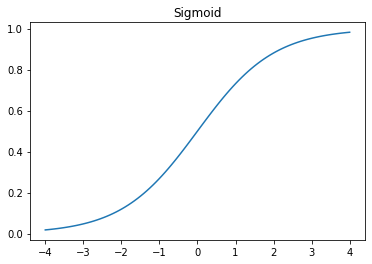

In [47]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

After the midpoint (0.5) all values below are 0 and all above are 1. This can now be used in the loss function.

In [49]:
def char_loss(preds, targets):
  preds = preds.sigmoid()
  # return mean of either: preds or (1-preds)
  return torch.where(preds == 1, 1 - preds, preds).mean()

### Mini-Batches
The loss function has been defined, we're ready to run gradient descent on the data. Well maybe not there's a few more things to iron out. The issue with running gradient descent on all our data is that would take quite a while; instead we could run it on each item, this would be much faster. The issue with operated on each example is that it doesn't account for other examples.


The Goldielox solution is to use mini-batches, it's faster than calculating the loss for the entire set but more accurate than doing it on each datum. FastAI  provides the ```DataLoader``` to handle this.

In [50]:
col = range(30)
# bs=batch size
dl = DataLoader(col, bs=5, shuffle=True)
list(dl)

[tensor([ 7, 24, 26, 17, 21]),
 tensor([ 5, 23, 19, 20,  9]),
 tensor([15, 14,  4, 27,  0]),
 tensor([18, 28, 13, 29,  3]),
 tensor([ 2, 11, 12, 22,  1]),
 tensor([10,  8, 25, 16,  6])]

## Implementation


In [54]:
path = Path('gdrive/MyDrive/Colab Notebooks/characters')
Path.BASE_PATH = path

In [55]:
fns = get_image_files(path)
fns

(#11708) [Path('A/A-9436.png'),Path('A/A-9831.png'),Path('A/A-9165.png'),Path('A/A-8987.png'),Path('A/A-9600.png'),Path('A/A-8851.png'),Path('A/A-8849.png'),Path('A/A-9252.png'),Path('A/A-10033.png'),Path('A/A-10026.png')...]

In [56]:
failed = verify_images(fns)
failed

(#0) []

Delete failed images

In [59]:
failed.map(Path.unlink);

### Data Curation

In [60]:
characters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

This defines how the data will be retreived and organised. The ```splitter``` divides the data into the training and validation sets.

In [61]:
dls = characters.dataloaders(path)

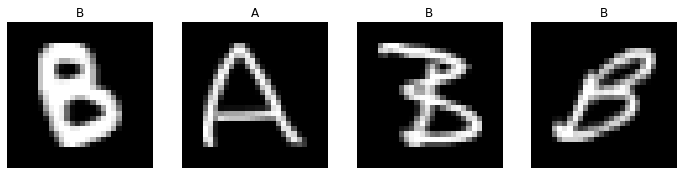

In [62]:
dls.valid.show_batch(max_n=4, nrows=1)

### Model Training

In [63]:
characters = characters.new(
    # item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = characters.dataloaders(path)

In [64]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.508953,0.269054,0.097821,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.166987,0.076390,0.026057,00:23
1,0.073278,0.031733,0.010252,00:23
2,0.037217,0.020744,0.006835,00:23
3,0.030348,0.012649,0.002990,00:24
4,0.021903,0.015822,0.003845,00:24


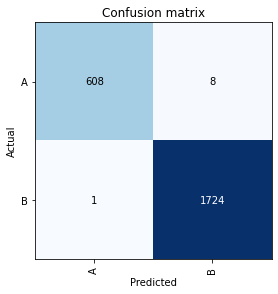

In [65]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

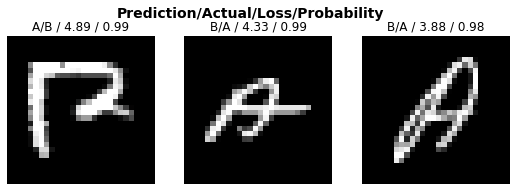

In [66]:
interp.plot_top_losses(3, nrows=1)

### Model Inference
Export model to app.

In [78]:
learn.export()

In [79]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [82]:
%mv export.pkl gdrive/MyDrive/Colab\ Notebooks/characters

In [83]:
%ls gdrive/MyDrive/Colab\ Notebooks/characters

A/  B/  export.pkl
